### Performance Metrics

## Success Indicators

You have now been asked to discover what key performance indicators (KPIs) will determine the success of the new design? Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.

- **Completion Rate:** The proportion of users who reach the final ‘confirm’ step.
- **Time Spent on Each Step:** The average duration users spend on each step.
- **Error Rates:** If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

## Redesign Outcome

Based on the chosen KPIs, how does the new design’s performance compare to the old one?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import reusable functions from utils directory
import sys
sys.path.append('../../utils')
import kpi_functions

In [3]:
df = pd.read_csv('../../data/clean/final_clean_client_df.csv')

In [4]:
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# check if any dates couldn't be converted (i.e., they are NaT)
inconsistent_dates = df['date_time'].isna().sum()

# if inconsistent_dates > 0, then there are invalid or mismatched date formats
if inconsistent_dates > 0:
    print(f'There are {inconsistent_dates} inconsistent or invalid date formats in the column.')
else:
    print('All dates in the column have the same format.')

All dates in the column have the same format.


In [5]:
kpi_df = df.copy()
kpi_df = kpi_df.drop(columns=['Unnamed: 0'])

# **Completion Rate**

In [6]:
def find_completion_rate(df):    
    clients_finished = df[df['step'] == 4]
    total_unique_clients = df['client_id'].nunique()
    unique_clients_finished = clients_finished['client_id'].nunique()
    print(f'Clients who finished the process: {unique_clients_finished} out of {total_unique_clients}.')
    
    completion_count = clients_finished.groupby('client_id').size().reset_index(name='completion_count')
    print("Completion count (grouped by client_id):")
    print(completion_count.head())
    
    df = df.merge(completion_count[['client_id', 'completion_count']], on='client_id', how='left') # add completion_count column

    df['completion_count'] = df['completion_count'].fillna(0).astype(int) # replace NaN with 0 for clients who never finished
    
    print("Final DataFrame with completion count:")
    print(df[['client_id', 'completion_count']].head())
    
    return df

kpi_df = find_completion_rate(kpi_df)

Clients who finished the process: 47787 out of 70594.
Completion count (grouped by client_id):
   client_id  completion_count
0        169                 1
1        555                 1
2        647                 1
3        722                 1
4       1195                 1
Final DataFrame with completion count:
   client_id  completion_count
0        169                 1
1        169                 1
2        169                 1
3        169                 1
4        169                 1


In [7]:
clients_finished = kpi_df[kpi_df['step'] == 4]['client_id'].nunique()
total_clients = kpi_df['client_id'].nunique()
clients_not_finished = total_clients - clients_finished

completion_rate = (clients_finished / total_clients) * 100

# # saved plot
# # pie chart
# plt.figure(figsize=(8, 8))
# plt.pie(
#     [clients_finished, clients_not_finished],
#     labels=['Finished', 'Not Finished'],
#     autopct='%1.1f%%',
#     colors=['lightgreen', 'salmon'],
#     startangle=140
# )
# plt.title('Completion Rate')
# plt.show()

# # saved plot
# # bar chart
# plt.figure(figsize=(8, 8))
# bars = plt.bar(['Total Clients', 'Completed Clients'], [total_clients, clients_finished], color=['lightgreen', 'salmon'])

# # add percentage annotation on top
# plt.text(1, clients_finished + 1, f'{completion_rate:.1f}%', ha='center', va='bottom', fontsize=12, color='black')

# plt.title('Total Clients vs Completed Clients')
# plt.ylabel('Number of Clients')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# **Time spent on each step**

New approach: calculate the time difference between consecutive steps for each client during each visit (this time taking `'visit_id'`):

- Sort the Data: Sort by `'client_id'`, `'visit_id'`, and `'step'` to ensure that steps are ordered for each client within each session.
- Calculate Time Spent on Each Step: For each `'client_id'` and `'visit_id'`, calculate the difference between the timestamp of the current step and the next step for that client.
- Group by `'client_id'` and `'step'`: Calculate the average time spent on each step.

In [8]:
# Call the function to calculate average time per step for each client
time_per_step_df = kpi_functions.calculate_average_time_per_step(kpi_df)

# Now, calculate the overall average time per step, regardless of client_id
overall_avg_time_per_step = time_per_step_df.groupby('step')['avg_time_minutes'].mean().reset_index(name='overall_avg_time_minutes')

# Print the results
print(overall_avg_time_per_step)


Median time spent across all steps: 0.92 minutes
   step  overall_avg_time_minutes
0     0                      0.00
1     1                      0.40
2     2                      1.15
3     3                      1.70
4     4                      0.92


In [9]:
step_name_mapping = {0: 'Start', 1: 'Step 1', 2: 'Step 2', 3: 'Step 3', 4: 'Finish'}
time_per_step_df['step_name'] = time_per_step_df['step'].map(step_name_mapping)

In [10]:
# plot saved

# Bar plot for average time spent per step (without hue)
# plt.figure(figsize=(10, 6))
# sns.barplot(x='step_name', y='avg_time_minutes', data=time_per_step_df, palette='viridis')

# plt.title('Average Time Spent per Step', fontsize=16)
# plt.xlabel('Step', fontsize=12)
# plt.ylabel('Time (minutes)', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [11]:
# plot saved
# Line plot for time spent across steps (can be useful to see trends)
# plt.figure(figsize=(10, 6))
# sns.lineplot(x='step_name', y='avg_time_minutes', data=time_per_step_df, marker='o', color='blue')
# plt.title('Average Time Spent per Step', fontsize=16)
# plt.xlabel('Step', fontsize=12)
# plt.ylabel('Time (minutes)', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [12]:
# plot saved
# Box plot to show distribution of time spent per step
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='step_name', y='avg_time_minutes', data=time_per_step_df)
# plt.title('Distribution of Time Spent per Step', fontsize=16)
# plt.xlabel('Step', fontsize=12)
# plt.ylabel('Time (minutes)', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# **Error Rates**
_(Constanza's code, taking `visit_id` into account)_

In [13]:
# drop existing columns to replace the values
kpi_df = kpi_df.drop(columns=['stepped_back', 'error_count'])

In [14]:
def calculate_error_count(df):
    df = df.sort_values(by=['client_id', 'visit_id', 'date_time'])

    # backward steps (errors) for each client within each visit
    df['stepped_back'] = df.groupby(['client_id', 'visit_id'])['step'].diff() < 0

    # Calculate total errors (total backward steps)
    total_errors = df['stepped_back'].sum()

    # total steps (rows in the dataframe)
    total_steps = len(df)

    # average error count per step (percentage of steps that are errors)
    avg_error_count_per_step = df['stepped_back'].mean()  # This gives the average proportion of steps that are errors
    print(f'Average error count per step: {avg_error_count_per_step:.2f}')

    # total error count per client (sum of backward steps per client)
    total_errors_per_client = df.groupby('client_id')['stepped_back'].sum()
    print(f'Total error count per client:\n{total_errors_per_client.head()}')

    # unique clients with errors
    clients_with_errors = (total_errors_per_client > 0).sum()
    error_rate_clients = (clients_with_errors / df['client_id'].nunique()) * 100
    print(f'Error rate (clients with errors): {error_rate_clients:.2f}%')

    # percentage of total steps that have errors
    error_rate_steps = (total_errors / total_steps) * 100  # % of steps that are errors
    print(f'Error rate (steps with errors): {error_rate_steps:.2f}%')

    # error rate per step (the proportion of steps that are errors)
    df['error_rate_per_step'] = df['stepped_back'].astype(int) / 1  # each row represents a step, so this is either 0 or 1
    error_rate_per_step = df['error_rate_per_step'].mean() * 100  # mean error rate per step
    print(f'Error rate per step: {error_rate_per_step:.2f}%')

    return df, total_errors_per_client

kpi_df, total_errors_per_client = calculate_error_count(kpi_df)
print(kpi_df.head())


Average error count per step: 0.08
Total error count per client:
client_id
169    0
555    0
647    0
722    2
934    0
Name: stepped_back, dtype: int64
Error rate (clients with errors): 29.95%
Error rate (steps with errors): 8.13%
Error rate per step: 8.13%
   client_id             visitor_id                      visit_id  step  \
4        169  201385055_71273495308  749567106_99161211863_557568     0   
3        169  201385055_71273495308  749567106_99161211863_557568     1   
2        169  201385055_71273495308  749567106_99161211863_557568     2   
1        169  201385055_71273495308  749567106_99161211863_557568     3   
0        169  201385055_71273495308  749567106_99161211863_557568     4   

            date_time  tenure_years  tenure_months  age gender  accounts  \
4 2017-04-12 20:19:36            21            262   47   Male         2   
3 2017-04-12 20:19:45            21            262   47   Male         2   
2 2017-04-12 20:20:31            21            262   47   Male

In [15]:
# saved plot

# # Plot: Error Rate (Clients with Errors) as a percentage
# clients_with_errors = (total_errors_per_client > 0).sum()  # Clients with at least 1 error
# total_clients = kpi_df['client_id'].nunique()  # Total number of unique clients
# error_rate_clients = (clients_with_errors / total_clients) * 100

# plt.figure(figsize=(8, 6))
# plt.pie([error_rate_clients, 100 - error_rate_clients], labels=['Clients With Errors', 'Clients with No Errors'], 
#         colors=['khaki', 'steelblue'], autopct='%1.1f%%', startangle=90)
# plt.title('Error Rate (Clients with Steps Back)')
# plt.show()

In [16]:
# saved plot

# # Line Plot with Average Errors per Step

# kpi_df['stepped_back'] = kpi_df.groupby(['client_id', 'visit_id'])['step'].diff() < 0

# # error rate (step-back rate) for each step
# step_error_rate = kpi_df.groupby('step')['stepped_back'].mean() * 100  # Percentage of clients with step back at each step

# # round error rates to whole numbers (no decimals)
# step_error_rate = step_error_rate.round(0)

# step_labels = {
#     0: 'Start', 
#     1: 'Step 1', 
#     2: 'Step 2', 
#     3: 'Step 3', 
#     4: 'Finish' 
# }

# # use the step labels instead of numeric values
# step_error_rate.index = step_error_rate.index.map(step_labels)

# # average error rate
# avg_error_rate = step_error_rate.mean()

# plt.figure(figsize=(12, 8))

# #  error rate for each step
# plt.plot(step_error_rate.index, step_error_rate.values, marker='o', color='orange', label='Step Back Rate', linestyle='-', alpha=0.7)

# # average error rate as a horizontal line
# plt.axhline(y=avg_error_rate, color='steelblue', linestyle='--', label=f'Average Step Back Rate: {avg_error_rate:.0f}%')

# plt.title('Error Rate for Each Step')
# plt.xlabel('Step')
# plt.ylabel('Rate (%)')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# **Redesign Outcome**
Based on the chosen KPIs, how does the new design’s performance compare to the old one?

For the project requirements and instructions for today’s tasks in full, please refer to the project brief. However, in order to keep on track you may refer to the daily goals outlined below:

By the end of day, we recommend you have:

Reviewed KPI and Metrics material.
Discovered what key performance indicators (KPIs) will determine the success of the new design
Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.
Evaluated how the new design’s performance compare to the old one, given the chosen KPIs (completion rate, time spent on each step and error rates).

### Evaluate how the new design’s performance compare to the old one, given the chosen KPIs 
- Completion rate
- Time spent on each step
- Error rates

In [17]:
# split in dfs for each variation
test_variation_df = kpi_df[kpi_df['variation'] == 'Test']
control_variation_df = kpi_df[kpi_df['variation'] == 'Control']
unknown_variation_df = kpi_df[kpi_df['variation'] == 'Unknown']

In [18]:
# drop empty rows
test_variation_df = test_variation_df.dropna()
control_variation_df = control_variation_df.dropna()
unknown_variation_df = unknown_variation_df.dropna()

Convert to `.csv`

In [19]:
# kpi_df.to_csv('kpi_df_clean.csv')

In [20]:
# test_variation_df.to_csv('test_variation_df_clean.csv')
# control_variation_df.to_csv('control_variation_df.csv')
# unknown_variation_df.to_csv('unknown_variation_df_clean.csv')

## Completion Rates

In [21]:
print('\nCompletion rate for Control:')
kpi_functions.find_completion_rate(control_variation_df)


Completion rate for Control:
Clients who finished the process: 15428 out ouf 23526.


(15428, 23526, 0.6557850888378814)

In [22]:
print('\nCompletion rate for Test:')
kpi_functions.find_completion_rate(test_variation_df)


Completion rate for Test:
Clients who finished the process: 18682 out ouf 26961.


(18682, 26961, 0.6929268202218019)

## Time spent on each step

In [23]:
kpi_functions.calculate_average_time_per_step(test_variation_df)
print("Average Time Spent Per Step:")
print(time_per_step_df[['step', 'avg_time_minutes']])

Median time spent across all steps: 1.18 minutes
Average Time Spent Per Step:
   step  avg_time_minutes
0     0              0.00
1     1              0.40
2     2              1.15
3     3              1.70
4     4              0.92


In [24]:
kpi_functions.calculate_average_time_per_step(control_variation_df)
print("\nAverage Time Spent Per Step:")
print(time_per_step_df[['step', 'avg_time_minutes']])

Median time spent across all steps: 0.88 minutes

Average Time Spent Per Step:
   step  avg_time_minutes
0     0              0.00
1     1              0.40
2     2              1.15
3     3              1.70
4     4              0.92


## Error Rate

In [25]:
kpi_functions.find_error_rate(test_variation_df)

Errors per client: client_id
1346       2
1516       3
1643       1
1836       1
1936       1
          ..
9994764    6
9995295    3
9998156    1
9999150    1
9999729    1
Length: 9009, dtype: int64
Total number of errors across all clients: 16229


(9009,
 client_id
 1346       2
 1516       3
 1643       1
 1836       1
 1936       1
           ..
 9994764    6
 9995295    3
 9998156    1
 9999150    1
 9999729    1
 Length: 9009, dtype: int64,
 np.int64(16229))

In [26]:
kpi_functions.find_error_rate(control_variation_df)

Errors per client: client_id
1028       2
1197       1
3647       1
7020       3
9229       3
          ..
9995084    1
9995265    1
9997391    2
9997470    3
9998346    1
Length: 6137, dtype: int64
Total number of errors across all clients: 9576


(6137,
 client_id
 1028       2
 1197       1
 3647       1
 7020       3
 9229       3
           ..
 9995084    1
 9995265    1
 9997391    2
 9997470    3
 9998346    1
 Length: 6137, dtype: int64,
 np.int64(9576))

In [27]:
kpi_functions.find_error_rate(unknown_variation_df)

Errors per client: client_id
722        2
1677       1
2078       3
8583       1
9536       1
          ..
9993293    4
9996478    2
9996952    2
9998430    1
9998980    1
Length: 6000, dtype: int64
Total number of errors across all clients: 10267


(6000,
 client_id
 722        2
 1677       1
 2078       3
 8583       1
 9536       1
           ..
 9993293    4
 9996478    2
 9996952    2
 9998430    1
 9998980    1
 Length: 6000, dtype: int64,
 np.int64(10267))

# Storing values

In [28]:
# store the results for test df
test_unique_finished, test_total_clients, test_completion_rate = kpi_functions.find_completion_rate(test_variation_df)
test_avg_time_per_step = kpi_functions.find_completion_rate(test_variation_df)
test_clients_with_errors, test_errors_per_client, test_total_errors = kpi_functions.find_error_rate(test_variation_df)

# store the results for control df
control_unique_finished, control_total_clients, control_completion_rate = kpi_functions.find_completion_rate(control_variation_df)
control_avg_time_per_step = kpi_functions.find_completion_rate(control_variation_df)
control_clients_with_errors, control_errors_per_client, control_total_errors = kpi_functions.find_error_rate(control_variation_df)

# store the results for unknown df
unknown_finished, unknown_total_clients, unknown_completion_rate = kpi_functions.find_completion_rate(unknown_variation_df)
unknown_avg_time_per_step = kpi_functions.find_completion_rate(unknown_variation_df)
unknown_clients_with_errors, unknown_errors_per_client, unknown_total_errors = kpi_functions.find_error_rate(unknown_variation_df)

Clients who finished the process: 18682 out ouf 26961.
Clients who finished the process: 18682 out ouf 26961.
Errors per client: client_id
1346       2
1516       3
1643       1
1836       1
1936       1
          ..
9994764    6
9995295    3
9998156    1
9999150    1
9999729    1
Length: 9009, dtype: int64
Total number of errors across all clients: 16229
Clients who finished the process: 15428 out ouf 23526.
Clients who finished the process: 15428 out ouf 23526.
Errors per client: client_id
1028       2
1197       1
3647       1
7020       3
9229       3
          ..
9995084    1
9995265    1
9997391    2
9997470    3
9998346    1
Length: 6137, dtype: int64
Total number of errors across all clients: 9576
Clients who finished the process: 13677 out ouf 20107.
Clients who finished the process: 13677 out ouf 20107.
Errors per client: client_id
722        2
1677       1
2078       3
8583       1
9536       1
          ..
9993293    4
9996478    2
9996952    2
9998430    1
9998980    1
Len

## **Testing Plots**

In [29]:
# def plot_completion_rate(test_completion_rate, control_completion_rate):
#     completion_rate_data = {
#         'Version': ['Test', 'Control'],
#         'Completion Rate': [test_completion_rate, control_completion_rate]
#     }
#     completion_rate_df = pd.DataFrame(completion_rate_data)
    
#     plt.figure(figsize=(8, 6))
#     ax = sns.barplot(x='Version', y='Completion Rate', data=completion_rate_df)
    
#     ax.patches[0].set_facecolor('lightblue')
#     ax.patches[1].set_facecolor('salmon')

#     plt.title('Completion Rate (Test vs Control)', fontsize=16)
#     plt.ylabel('Rate (%)')
    
#     plt.show()

In [30]:
# plot saved
# plot_completion_rate(test_completion_rate, control_completion_rate)

In [31]:
# def plot_error_rate(test_clients_with_errors, control_clients_with_errors, test_total_errors, control_total_errors):
#     clients_error_data = {
#         'Variation': ['Test', 'Control'],
#         'Clients': [test_clients_with_errors, control_clients_with_errors]
#     }
#     clients_error_df = pd.DataFrame(clients_error_data)
    
#     plt.figure(figsize=(8, 6))
#     ax = sns.barplot(x='Variation', y='Clients', data=clients_error_df)
    
#     ax.patches[0].set_facecolor('cadetblue')
#     ax.patches[1].set_facecolor('lightcoral')    
    
#     plt.title('Error Count per Client (Test vs Control)', fontsize=16)
#     plt.show()

#     total_errors_data = {
#         'Variation': ['Test', 'Control'],
#         'Total Errors': [test_total_errors, control_total_errors]
#     }
#     total_errors_df = pd.DataFrame(total_errors_data)
    
#     plt.figure(figsize=(8, 6))
#     ax = sns.barplot(x='Variation', y='Total Errors', data=total_errors_df)
    
#     ax.patches[0].set_facecolor('cadetblue')
#     ax.patches[1].set_facecolor('lightcoral')    
    
#     plt.title('Error Count per Variation (Test vs Control)', fontsize=16)
#     plt.show()

In [32]:
# plots saved
# plot_error_rate(test_clients_with_errors, control_clients_with_errors, test_total_errors, control_total_errors)

In [37]:
# **Completion Rate Comparison - Pie Chart**

def plot_completion_rate_pie(test_completion_rate, control_completion_rate, unknown_completion_rate):
    completion_rate_data = {
        'Version': ['Test', 'Control', 'Unknown'],
        'Completion Rate': [test_completion_rate, control_completion_rate, unknown_completion_rate]
    }
    completion_rate_df = pd.DataFrame(completion_rate_data)
    
    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(completion_rate_df['Completion Rate'], labels=completion_rate_df['Version'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon', 'lightgray'])
    plt.title('Completion Rate (Test, Control and Unknown Variation)')
    plt.show()

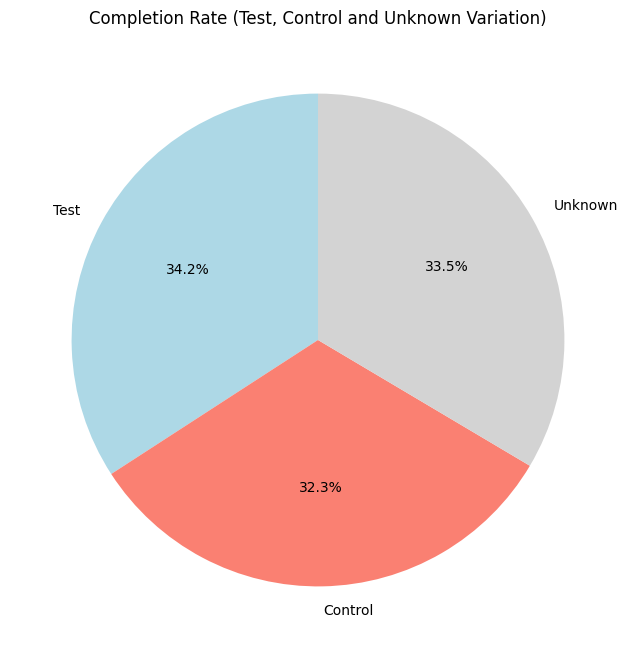

In [38]:
# plot saved
plot_completion_rate_pie(test_completion_rate, control_completion_rate, unknown_completion_rate)

In [35]:
def generate_error_rate_df(df):
    total_errors_per_client = df[df['stepped_back']].groupby('client_id').size()

    total_actions_per_client = df.groupby('client_id').size()

    error_rate = total_errors_per_client / total_actions_per_client

    error_rate_df = pd.DataFrame({
        'client_id': total_actions_per_client.index,
        'total_errors': total_errors_per_client,
        'total_actions': total_actions_per_client,
        'error_rate': error_rate
    })

    error_rate_df['total_errors'] = error_rate_df['total_errors'].fillna(0).astype(int)
    error_rate_df['error_rate'] = error_rate_df['error_rate'].fillna(0).round(2)

    error_rate_df['error_percentage'] = error_rate_df['error_rate'] * 100

    error_rate_df['has_error'] = error_rate_df['total_errors'] > 0


    if 'timestamp' in df.columns:
        df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
        error_frequency = df[df['stepped_back']].groupby(['client_id', 'hour']).size().unstack(fill_value=0)
        error_rate_df['avg_hourly_errors'] = error_frequency.mean(axis=1)

    return error_rate_df


error_rate_df = generate_error_rate_df(kpi_df)

print(error_rate_df.head())


           client_id  total_errors  total_actions  error_rate  \
client_id                                                       
169              169             0              5        0.00   
555              555             0              5        0.00   
647              647             0              5        0.00   
722              722             2              9        0.22   
934              934             0              4        0.00   

           error_percentage  has_error  
client_id                               
169                     0.0      False  
555                     0.0      False  
647                     0.0      False  
722                    22.0       True  
934                     0.0      False  


In [36]:
# plot saved

# # Pie chart of Clients with Errors vs. Clients Without Errors
# clients_with_errors = error_rate_df[error_rate_df['has_error']]['client_id'].nunique()
# clients_without_errors = error_rate_df[~error_rate_df['has_error']]['client_id'].nunique()

# labels = ['Clients with Errors', 'Clients without Errors']
# sizes = [clients_with_errors, clients_without_errors]
# colors = ['#ff9999','#66b3ff']
# plt.figure(figsize=(8, 8))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.1, 0))
# plt.title('Clients with and without Errors')
# plt.show()
